In [1]:
!pip3 install --upgrade ibm-generative-ai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip3 install genai


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# %capture --no-stderr
%pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph 

  Using cached tiktoken-0.7.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.6 kB)
Using cached tiktoken-0.7.0-cp311-cp311-macosx_11_0_arm64.whl (907 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.1/87.1 kB 868.4 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tiktoken
    Found existing installation: tiktoken 0.3.3
    Uninstalling tiktoken-0.3.3:
      Successfully uninstalled tiktoken-0.3.3
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.5
    Uninstalling langgraph-0.2.5:
      Successfully uninstalled langgraph-0.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.1.22 requires openai<2.0.0,>=1.40.0, but you have openai 0.27.10 which is incompatible.
ragas 0.1.14 requires openai>1, but you have openai 0.27.10 which is incompatible.
llama-index-core 0.10.58 requires openai>=1.1.0, but you have openai 

In [83]:
import warnings, os
warnings.filterwarnings("ignore")
from langchain_ibm import WatsonxLLM
from dotenv import load_dotenv
# load_dotenv(override=True)

from genai import Client, Credentials

from genai.extensions.langchain import LangChainInterface
from genai.schema import (
    DecodingMethod,
    TextGenerationParameters,
)
# from langchain_ibm import WatsonxLLM
# from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

credentials = Credentials(api_key="pak-6TdyOvhiJer2r777pkfGALfQe3O_IPtmJFl1Rp1DVBI", api_endpoint="https://bam-api.res.ibm.com" )
def bam_model(model_id='meta-llama/llama-3-8b-instruct', decoding_method='greedy', max_new_tokens=1000, 
              min_new_tokens=1, temperature=0.5, top_k=50, top_p=1, repetition_penalty=1):

    # if decoding_method == 'greedy':
    #     decoding_method = DecodingMethod.GREEDY
    #     parameters=TextGenerationParameters(
    #         decoding_method=decoding_method,
    #         max_new_tokens=max_new_tokens,
    #         min_new_tokens=min_new_tokens,
    #         repetition_penalty=repetition_penalty
    #     )
    # else:
    #     decoding_method = DecodingMethod.SAMPLE
    #     parameters=TextGenerationParameters(
    #         decoding_method=decoding_method,
    #         max_new_tokens=max_new_tokens,
    #         min_new_tokens=min_new_tokens,
    #         temperature=temperature,
    #         top_k=top_k,
    #         top_p=top_p,
    #         repetition_penalty=repetition_penalty
    #     )

    # llm = LangChainInterface(
    #     model_id=model_id,
    #     client=Client(credentials=credentials),
    #     parameters=parameters,
    # )

    parameters = {
    "decoding_method": "sample",
    "max_new_tokens": 100,
    "min_new_tokens": 1,
    "temperature": 0.5,
    "top_k": 50,
    "top_p": 1,
    }
    load_dotenv()
    api_key = os.getenv("api_key", None)
    ibm_cloud_url = os.getenv("ibm_cloud_url", None)
    project_id = os.getenv("project_id", None)
    if api_key is None or ibm_cloud_url is None or project_id is None:
        print("Ensure you copied the .env file that you created earlier into the same directory as this notebook")
    else:
        creds = {
        "url": ibm_cloud_url,
        "apikey": api_key 
    }
    
    llm = WatsonxLLM(
    model_id=model_id,
    url=ibm_cloud_url,
    apikey=api_key,
    project_id=project_id,
    params=parameters,
)
    return llm

    #return llm


In [84]:
local_llm = bam_model()
# print(local_llm.invoke(prompt))


# local_llm = "llama3"
model_tested = "meta-llama/llama-3-8b-instruct"
metadata = f"Self-RAG, {model_tested}"

In [85]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings, HuggingFaceBgeEmbeddings

# Load
# urls = [
#     "https://lilianweng.github.io/posts/2023-06-23-agent/",
#     "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
#     "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
# ]
# docs = [WebBaseLoader(url).load() for url in urls]
# docs_list = [item for sublist in docs for item in sublist]

# Split
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=500, chunk_overlap=100
# )
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyMuPDFLoader
loader_mu = PyMuPDFLoader("/Users/deekshas/Documents/selfRAG_v1/RFP_for_Support_Center_and_Staffing_04232024.pdf")
pages = loader_mu.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=800,
    chunk_overlap=60
)
docs_split = text_splitter.split_documents(pages)
# docs = [doc.page_content for doc in docs_split]
# doc_splits = text_splitter.split_documents(docs_list)

# Embed and index
embedding = HuggingFaceBgeEmbeddings()

# Index
vectorstore = Chroma.from_documents(
    documents=docs_split,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

In [86]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

os.environ['TOKENIZERS_PARALLELISM']='true'

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing relevance of a retrieved document to a user question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "watsonx challenge"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [87]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 

    Use three sentences maximum and keep the answer concise.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Question: {question} 
    Documents: {documents} 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = local_llm #ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

 The WatsonX Challenge is an internal event for IBMers to gain hands-on experience with WatsonX and Granite models. The challenge allows teams to bring their own data to make their projects relevant to their daily work.


In [88]:
### Hallucination Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is grounded in / supported by a set of facts. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}
    Give a binary score 'yes' or 'no' score to indicate whether the answer is grounded in / supported by a set of facts. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)

hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader.invoke({"documents": docs, "generation": generation})

{'score': 'yes'}

In [89]:
### Answer Grader

# LLM
llm = local_llm  #ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a grader assessing whether an answer is useful to resolve a question. \n 
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the answer:
    \n ------- \n
    {generation} 
    \n ------- \n
    Here is the question: {question}
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. \n
    Provide the binary score as a JSON with a single key 'score' and no preamble or explanation.
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

answer_grader = prompt | llm | JsonOutputParser()
answer_grader.invoke({"question": question, "generation": generation})

{'score': 'yes'}

In [90]:
### Question Re-writer

# LLM
llm = local_llm  #ChatOllama(model=local_llm, temperature=0)

# Prompt
re_write_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You a question re-writer that converts an input question to a better version that is optimized \n 
    for vectorstore retrieval. Look at the initial and formulate an improved question. \n
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here is the initial question: {question}
    provide an improved question with no preamble or explanation: \n 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

'\n\nWhat are the key challenges associated with WatsonX?'

In [91]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [92]:
### Nodes


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"documents": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score["score"]

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score["score"]
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

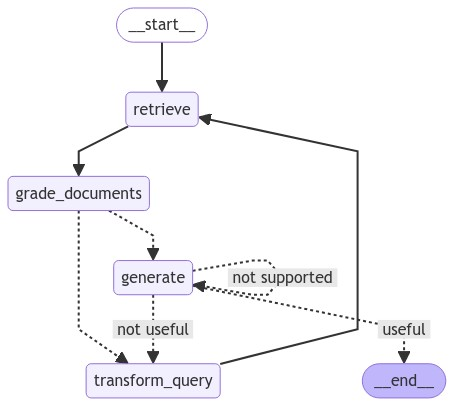

In [29]:
from langgraph.graph import END, StateGraph, START
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [69]:
from pprint import pprint

# Run
inputs = {"question": "Is there a defined quantity of resources for service delivery? Is there a specified profile for the resources, including certifications or defined years of experience?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    print("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"

---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"

---

---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
"Node 'generate':"

---

(' Yes, there is a defined quantity of resources for service delivery. The RFP '
 'specifies the required job categories, including Level 1 Helpdesk Analysts, '
 'Level 2 Helpdesk Analysts, and Customer Service Supervisors, with defined '
 'experience and certifications.')


In [70]:
print(value["generation"])

 Yes, there is a defined quantity of resources for service delivery. The RFP specifies the required job categories, including Level 1 Helpdesk Analysts, Level 2 Helpdesk Analysts, and Customer Service Supervisors, with defined experience and certifications.


In [80]:
import uuid


def predict_custom_agent_local_answer(example: dict):
    config = {"configurable": {"thread_id": str(uuid.uuid4())}, 
              "recursion_limit": 25  # Set the recursion limit here
              }
    
    try:
        state_dict = app.invoke(
            {"question": example["input"]}, config
        )
        return {"response": state_dict["generation"]}
    except Exception as e:
        # Catch any other exceptions and return a fallback response
        return {"response": "Unanswerable"}


example = {"input": "Is there a defined quantity of resources for service delivery? Is there a specified profile for the resources, including certifications or defined years of experience?"}
response = predict_custom_agent_local_answer(example)
print(response)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
{'response': 'Unanswerable'}


In [18]:
example = {"input": "When is next ce only all hands meet"}
response = predict_custom_agent_local_answer(example)
print(response)

---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---
{'response': ' The next CE only all hands meet is scheduled to take place at the end of the month.'}
